# ***Who Grade Binary Classification***

This notebook shows the process of classifying samples into binary who grade (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [10]:
import gc
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Tuple
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn import metrics as s_metrics
from sklearn.model_selection import train_test_split

# Define default font size
plt.rcParams.update({'font.size': 12})

### ***Consistency***
Next, let's make sure notebook is not random:

In [11]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [12]:
# Define folder that contains the dhg dataset
DHG_PATH = "./DHG/"
# Define folder that contains the low dimension dataset
LEVEL_3_PATH = f"{DHG_PATH}/level_3"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define path to save plots
FIGURES_PATH = "./figures/binary_who_grade_classification_low"

### ***Creating output folders***

Next, let's create the output folders:

In [13]:
# Create output folder if doesn't exist
Path(FIGURES_PATH).mkdir(parents=True, exist_ok=True)

### ***Reading MSI metadata file***

Next, let's read the metadata file:

In [14]:
# Read metadata csv
metadata_df = pd.read_csv(METADATA_PATH)

# Separate section and replica
s_metadata_df = metadata_df[metadata_df.sample_type == "section"]
r_metadata_df = metadata_df[metadata_df.sample_type == "replica"]

### ***Reading data***

Next, let's read the low dimension data:

In [15]:
s_groups = dict(zip(s_metadata_df.sample_file_name, s_metadata_df.file_name))
s_data = pd.read_csv(os.path.join(LEVEL_3_PATH, "section.csv"))
s_data["group"] = s_data.file_name.map(lambda x: s_groups[x])
s_data["label"] = (s_data["who_grade"] > 3).astype(int)

r_groups = dict(zip(r_metadata_df.sample_file_name, r_metadata_df.file_name))
r_data = pd.read_csv(os.path.join(LEVEL_3_PATH, "replica.csv"))
r_data["group"] = r_data.file_name.map(lambda x: r_groups[x])
r_data["label"] = (r_data["who_grade"] > 3).astype(int)

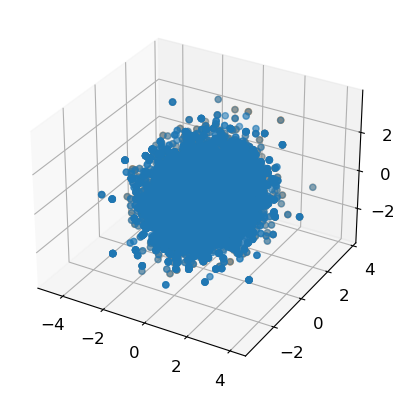

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(s_data.loc[s_data.label == 0, "Var 1"], s_data.loc[s_data.label == 0, "Var 3"], s_data.loc[s_data.label == 0, "Var 4"])
ax.scatter(s_data.loc[s_data.label == 1, "Var 1"], s_data.loc[s_data.label == 1, "Var 3"], s_data.loc[s_data.label == 1, "Var 4"], alpha=0.3)
plt.show()


In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# Initialize column to store prediction
r_data["prediction"] = -1.0

# Get X and y
X = r_data.loc[:, "Var 0":"Var 4"]
y = r_data.loc[:, "label"]

# Get groups to divide for Leave one image out
groups = r_data.loc[:, "group"]

# Get group names to identity each iteration
groups_names = np.unique(groups)

# Create leave one group out
logo = LeaveOneGroupOut()

# Loop over each split
for train_index, test_index in logo.split(X, y, groups):
  # Get test and train data and labels
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  
  #
  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)

  # Train model
  clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric=balanced_accuracy_score).fit(X_train, y_train)

  # Predict labels
  r_data.iloc[test_index,
              r_data.columns.get_loc("prediction")] = clf.predict(scaler.transform(X_test))

# Accumulate prediction of each spectra to get tissue prediction
y, y_hat = r_data.groupby("file_name").aggregate(
    {
        "label": "mean",
        "prediction": "mean"
    }
).T.to_numpy()

c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[11:28:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:34] WARNING:

In [8]:
print(s_metrics.balanced_accuracy_score(y.astype(int), (y_hat > 0.5).astype(int)))

0.4642857142857143


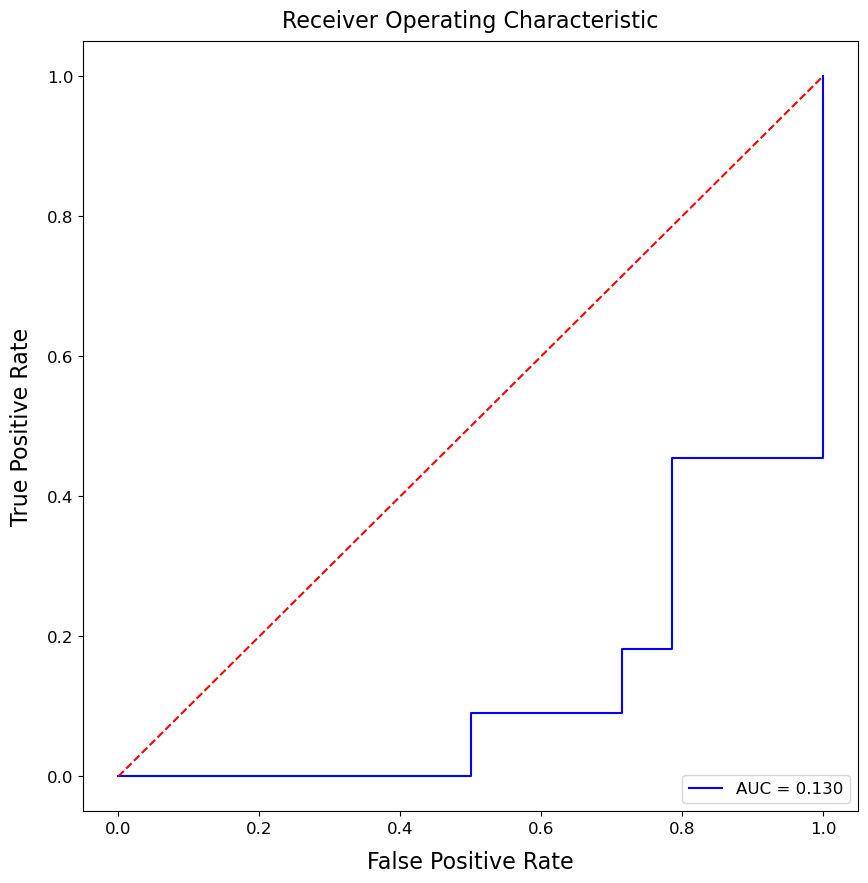

In [9]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = s_metrics.roc_curve(
    y, y_hat
)
# Compute Area Under the Curve
roc_auc = s_metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

In [22]:
c = {}
a = np.concatenate((X_meta_test, y_test ,np.expand_dims(y_hat, axis=1)), axis=1)
b = np.unique(a[:, 0])
for i in b:
  c[i] = (a[a[:, 0] == i][:, 3]).mean()
  t[i] = (a[a[:, 0] == i][:, 3]).mean()

In [25]:
b

array(['HG 10-s', 'HG 9-s'], dtype=object)

In [13]:
X_meta_train[test_index]

IndexError: index 31745 is out of bounds for axis 0 with size 30718

In [78]:
logo.split(X, y, groups)

<generator object BaseCrossValidator.split at 0x0000015B7A8AFAC0>

In [99]:
from sklearn.model_selection import cross_validate


X = s_data.loc[:, "Var 0":"Var 9"].to_numpy()
y = s_data.loc[:, "label"].to_numpy()
groups = s_data.loc[:, "group"].to_numpy()
cv_results = cross_validate(RandomForestClassifier(), X, y, cv=LeaveOneGroupOut(), groups=groups)

In [100]:
cv_results

{'fit_time': array([6.00730896, 5.20399952, 5.67400122, 5.96994448, 6.14699936,
        5.11699843, 6.07600117, 4.89199495, 5.96600008]),
 'score_time': array([0.03199601, 0.06700349, 0.05499887, 0.04900241, 0.04100156,
        0.10799861, 0.03100252, 0.10200095, 0.02900314]),
 'test_score': array([0.07458405, 0.45845954, 0.68168835, 0.50716561, 0.28991384,
        0.21135176, 0.80567082, 0.63548432, 0.28101117])}

In [76]:
cv_results

{'fit_time': array([5.52598667, 5.47199726, 5.52696609, 5.61702943, 5.6610322 ,
        5.42099667, 5.52699995, 5.73199868, 5.42603064]),
 'score_time': array([0.05399966, 0.05697227, 0.06200027, 0.06000209, 0.05999637,
        0.06000185, 0.06799984, 0.06000042, 0.06099367]),
 'test_score': array([0.49708576, 0.61493615, 0.73514714, 0.72654081, 0.74430872,
        0.53026097, 0.76846197, 0.7098834 , 0.76457524])}

### ***Get single spectra information from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all images:

In [6]:
# Create lists to store each spectra's info
spectras_info = []

# Loop over each MSI
for index, row in tqdm(
    metadata_df.iterrows(), total=metadata_df.shape[0], desc="MSI Loop"
):
  # Parse the MSI file
  with ImzMLParser(
      os.path.join(LEVEL_2_PATH, f"{row.sample_file_name}.imzML")
  ) as reader:
    # Threshold image
    thresh_img = np.load(
        os.path.join(LEVEL_2_PATH, f"{row.sample_file_name}.npy")
    )

    # Loop over each spectra
    spectra_info = []
    for idx, (x, y, z) in tqdm(
        enumerate(reader.coordinates), total=len(reader.coordinates),
        desc="Spectra Loop"
    ):
      # Append spectra info
      spectras_info.append(
          [
              row.sample_file_name, row.sample_type, row.sample_number,
              row.histology, row.who_grade, row.label, x, y, idx,
              (True if thresh_img[y - 1, x - 1] else False)
          ]
      )

# Convert to data frame
spectras_info = pd.DataFrame(
    spectras_info, columns=[
        "file_name", "sample_type", "sample_number", "histology", "who_grade",
        "label", "x_coordinate", "y_coordinate", "idx", "is_tissue"
    ]
)

# Separate section and replica
s_spectras_info = spectras_info[spectras_info.sample_type == "section"]
r_spectras_info = spectras_info[spectras_info.sample_type == "replica"]

MSI Loop: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [7]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(LEVEL_2_PATH, f"{file_name}.imzML"))
    for file_name in metadata_df.sample_file_name.unique()
}

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [8]:
def map_record(file_name: tf.Tensor, idx: tf.Tensor,
               label: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map a record to model input (spectra) and output (label).

  Args:
      file_name (tf.Tensor): Record file name to get spectra.
      idx (tf.Tensor): Record index to get spectra.
      label (tf.Tensor): Record label.

  Returns:
      Tuple[np.ndarray, int]: Input (spectra) and output (label).
  
  """
  # Decoding from the EagerTensor object
  file_name, idx, label = (file_name.numpy(), idx.numpy(), label.numpy())

  # Decode bytes to str
  file_name = file_name.decode('utf-8')

  # Reading spectra from parser
  mzs, spectra = parsers[file_name].getspectrum(idx)

  # Return spectra and label
  return (spectra[((mzs >= 600) & (mzs <= 900))], label)


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): Input (spectra)
      y (tf.Tensor): Output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: Input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(
    file_names: np.ndarray, indexes: np.ndarray, labels: np.ndarray,
    batch_size: int, shuffle: bool
) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      file_names (np.ndarray): File names of the dataset.
      indexes (np.ndarray): Indexes of the dataset.
      labels (np.ndarray): Labels of the dataset.
      batch_size (int): Batch size.
      shuffle (bool): Flag to indicate if to shuffle or not.

  Returns:
      tf.data.Dataset: Dataset
  """
  # Create dataset
  ds = tf.data.Dataset.from_tensor_slices((file_names, indexes, labels))
  # Shuffle the data
  if shuffle:
    ds = ds.shuffle(len(file_names), seed=SEED)
  # Map record to model input
  ds = ds.map(
      lambda i, j, k: tf.
      py_function(func=map_record, inp=[i, j, k], Tout=[tf.float32, tf.int32])
  )
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batch's to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [9]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: Classification model.
  
  """
  return tf.keras.Sequential(
      [
          layers.InputLayer(input_shape=(SPECTRA_DIM,)),
          layers.Dense(1024),
          layers.LeakyReLU(alpha=0.2),
          layers.BatchNormalization(),
          layers.Dropout(0.3),
          layers.Dense(1024),
          layers.LeakyReLU(alpha=0.2),
          layers.BatchNormalization(),
          layers.Dropout(0.3),
          layers.Dense(512),
          layers.LeakyReLU(alpha=0.2),
          layers.BatchNormalization(),
          layers.Dropout(0.3),
          layers.Dense(1, activation='sigmoid')
      ]
  )

### ***Section classification:***
Next, let's apply classification on section samples.

#### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [10]:
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in s_metadata_df.groupby("file_name"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = s_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & s_spectras_info.is_tissue)

  # Filter training data
  s_spectras_info_train = s_spectras_info.loc[train_filter]

  # Get x and y data for training
  X = s_spectras_info_train[["file_name", "idx"]].to_numpy()
  y = s_spectras_info_train["label"].to_numpy()

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Shuffle training labels
  # np.random.shuffle(y_train)

  # Create data generators
  train_generator = create_ds(
      X_train[:, 0], X_train[:, 1].astype("int"), y_train, BATCH_SIZE, True
  )
  validation_generator = create_ds(
      X_val[:, 0], X_val[:, 1].astype("int"), y_val, BATCH_SIZE, True
  )

  # Calculate class weights to make sure no imbalance data affect
  neg, pos = np.bincount(y_train.astype(int))
  weight_for_0 = (1 / neg) * ((neg + pos) / 2.0)
  weight_for_1 = (1 / pos) * ((neg + pos) / 2.0)
  class_weight = {0: weight_for_0, 1: weight_for_1}

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"section_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False, monitor="val_auc",
      mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  classification_model.compile(
      optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
      loss=losses.BinaryCrossentropy(label_smoothing=0.1), metrics=[
          k_metrics.TruePositives(name='tp'),
          k_metrics.FalsePositives(name='fp'),
          k_metrics.TrueNegatives(name='tn'),
          k_metrics.FalseNegatives(name='fn'),
          k_metrics.BinaryAccuracy(name='accuracy'),
          k_metrics.Precision(name='precision'),
          k_metrics.Recall(name='recall'),
          k_metrics.AUC(name='auc'),
          k_metrics.AUC(name='prc', curve='PR')
      ]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback,
                 model_es_callback], class_weight=class_weight
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

Epoch 1/100
96/96 [==============================] - 28s 267ms/step - loss: 0.3303 - tp: 15059.0000 - fp: 406.0000 - tn: 8151.0000 - fn: 924.0000 - accuracy: 0.9458 - precision: 0.9737 - recall: 0.9422 - auc: 0.9829 - prc: 0.9895 - val_loss: 0.2952 - val_tp: 3931.0000 - val_fp: 23.0000 - val_tn: 2117.0000 - val_fn: 65.0000 - val_accuracy: 0.9857 - val_precision: 0.9942 - val_recall: 0.9837 - val_auc: 0.9989 - val_prc: 0.9994
INFO:tensorflow:Assets written to: ./models/binary_who_grade_classification\section_excluded_HG 1-s\assets
Epoch 2/100
96/96 [==============================] - 26s 267ms/step - loss: 0.2303 - tp: 15919.0000 - fp: 37.0000 - tn: 8520.0000 - fn: 64.0000 - accuracy: 0.9959 - precision: 0.9977 - recall: 0.9960 - auc: 0.9998 - prc: 0.9999 - val_loss: 0.2286 - val_tp: 3961.0000 - val_fp: 32.0000 - val_tn: 2108.0000 - val_fn: 35.0000 - val_accuracy: 0.9891 - val_precision: 0.9920 - val_recall: 0.9912 - val_auc: 0.9994 - val_prc: 0.9997
INFO:tensorflow:Assets written to: ./

In [13]:
# Create data frame of train metrics
train_metrics_df = pd.DataFrame.from_dict(
    train_metrics, orient='index', columns=[
        "loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall",
        "auc", "prc"
    ]
)
# Save data frame
train_metrics_df.to_csv(f"{FIGURES_PATH}/section_train_metrics.csv")
# Print
train_metrics_df

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
HG 1-s,0.214413,15981.0,0.0,8557.0,2.0,0.999919,1.0,0.999875,0.999992,0.999996
HG 11-11-12-s,0.200408,11114.0,0.0,9952.0,0.0,1.000000,1.0,1.000000,1.000000,1.000000
HG 14-13-s,0.206413,13460.0,0.0,9952.0,2.0,0.999915,1.0,0.999851,1.000000,1.000000
HG 16-15-s,0.198845,15003.0,0.0,8922.0,0.0,1.000000,1.0,1.000000,1.000000,1.000000
HG 19-18-s,0.219986,15978.0,0.0,8373.0,5.0,0.999795,1.0,0.999687,1.000000,1.000000
HG 29-25-23-21-20-s,0.199231,14901.0,0.0,4607.0,0.0,1.000000,1.0,1.000000,1.000000,1.000000
HG 6-7-s,0.201170,14826.0,0.0,9952.0,0.0,1.000000,1.0,1.000000,1.000000,1.000000
HG 8-12-5-4-3-2-s,0.199710,9217.0,0.0,9347.0,0.0,1.000000,1.0,1.000000,1.000000,1.000000
HG 9-10-s,0.204836,14620.0,0.0,9952.0,2.0,0.999919,1.0,0.999863,1.000000,1.000000


In [14]:
# Create data frame of validation metrics
validation_metrics_df = pd.DataFrame.from_dict(
    validation_metrics, orient='index', columns=[
        "loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall",
        "auc", "prc"
    ]
)
# Save data frame
validation_metrics_df.to_csv(f"{FIGURES_PATH}/section_validation_metrics.csv")
# Print
validation_metrics_df

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
HG 1-s,0.228632,3961.0,32.0,2108.0,35.0,0.989081,0.991986,0.991241,0.999432,0.999701
HG 11-11-12-s,0.220786,2770.0,54.0,2434.0,9.0,0.988039,0.980878,0.996761,0.999397,0.999389
HG 14-13-s,0.226356,3360.0,71.0,2417.0,6.0,0.986847,0.979306,0.998217,0.999561,0.999681
HG 16-15-s,0.215269,3739.0,48.0,2183.0,12.0,0.989970,0.987325,0.996801,0.999599,0.999756
HG 19-18-s,0.236499,3954.0,37.0,2057.0,42.0,0.987028,0.990729,0.989489,0.999209,0.999585
HG 29-25-23-21-20-s,0.207153,3724.0,17.0,1135.0,1.0,0.996309,0.995456,0.999732,0.999897,0.999968
HG 6-7-s,0.221501,3695.0,78.0,2410.0,12.0,0.985472,0.979327,0.996763,0.999530,0.999681
HG 8-12-5-4-3-2-s,0.211908,2295.0,22.0,2315.0,10.0,0.993106,0.990505,0.995662,0.999821,0.999818
HG 9-10-s,0.222715,3643.0,63.0,2425.0,13.0,0.987630,0.983001,0.996444,0.999590,0.999720


#### ***Evaluation on section tissue spectra's:***

Next, let's get the prediction of each of left out section sample spectra's:

In [15]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it]


Next, let's get some statistics about each left out section sample predictions:

In [16]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/section_section_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 11_1-s,0.1178782433,0.9793278575,0.9409821033,0.9074674845,0.0915903375,1,1
HG 11_2-s,0.2037850618,0.9770405293,0.9267228246,0.8882014155,0.0980030447,1,1
HG 12-s,0.1444269121,0.9769482613,0.9471349716,0.8631649017,0.1599723697,1,1
HG 14-s,0.0555330403,0.9784049392,0.5146278143,0.5377213955,0.2828080058,1,1
HG 13-s,0.1180284843,0.9833715558,0.8601261377,0.8102133274,0.1554909199,1,1
HG 15-s,0.0378800780,0.9532107115,0.0755036175,0.1695203334,0.2015978694,1,0
HG 16-s,0.0502717160,0.9554761648,0.8551036716,0.7644441128,0.2157314122,0,1
HG 19-s,0.0827140957,0.9915809035,0.3159875572,0.3947927654,0.2259509414,0,0
HG 18-s,0.0609604046,0.9966552258,0.1666080505,0.2661187947,0.2381140739,0,0


Next, let's evaluate the classification performance image-wise:

In [17]:
# Get accuracy
accuracy = s_metrics.accuracy_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get balanced accuracy
b_accuracy = s_metrics.balanced_accuracy_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get precision
precision = s_metrics.precision_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get recall
recall = s_metrics.recall_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get  f1 score
f1 = s_metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_section_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.680
Balanced  Accuracy: 0.653
Precision: 0.750
Recall: 0.750
F1 score: 0.750



Next, let's plot the roc curve image-wise:

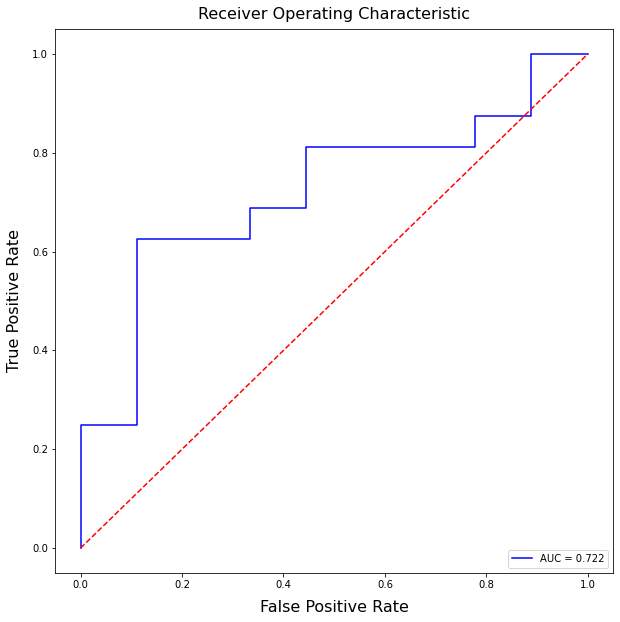

In [18]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = s_metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = s_metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

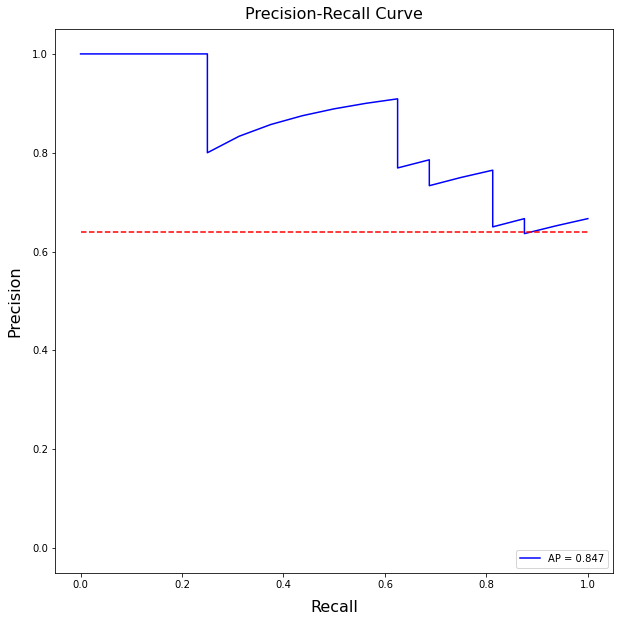

In [19]:
# Compute Receiver operating characteristic
precision, recall, thresholds = s_metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = s_metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [20]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = s_metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = s_metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = s_metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = s_metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = s_metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_section_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.677
Balanced  Accuracy: 0.658
Precision: 0.746
Recall: 0.735
F1 score: 0.740



Next, let's plot the roc curve spectra-wise:

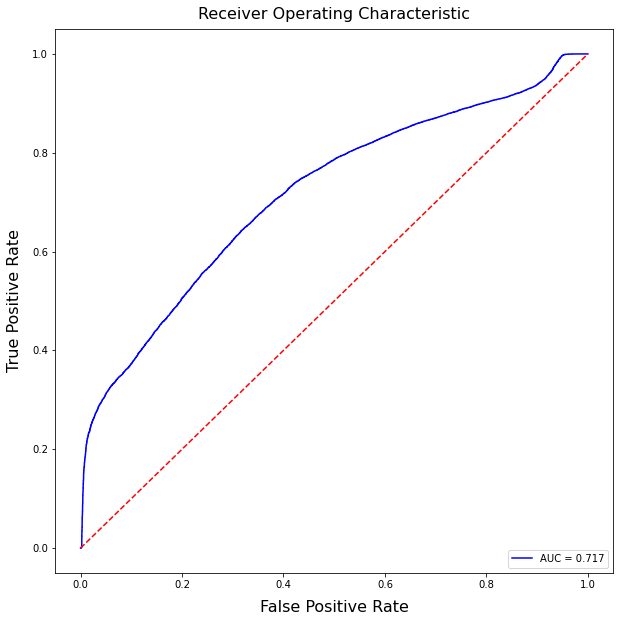

In [21]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = s_metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = s_metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

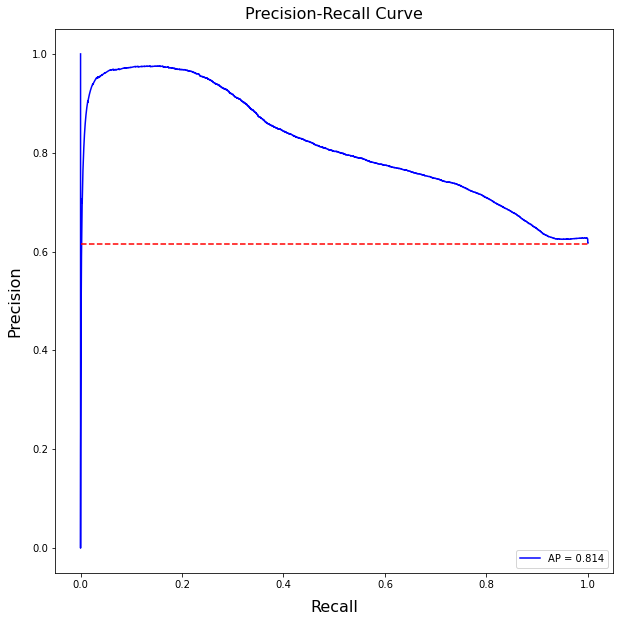

In [28]:
# Compute Receiver operating characteristic
precision, recall, thresholds = s_metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = s_metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

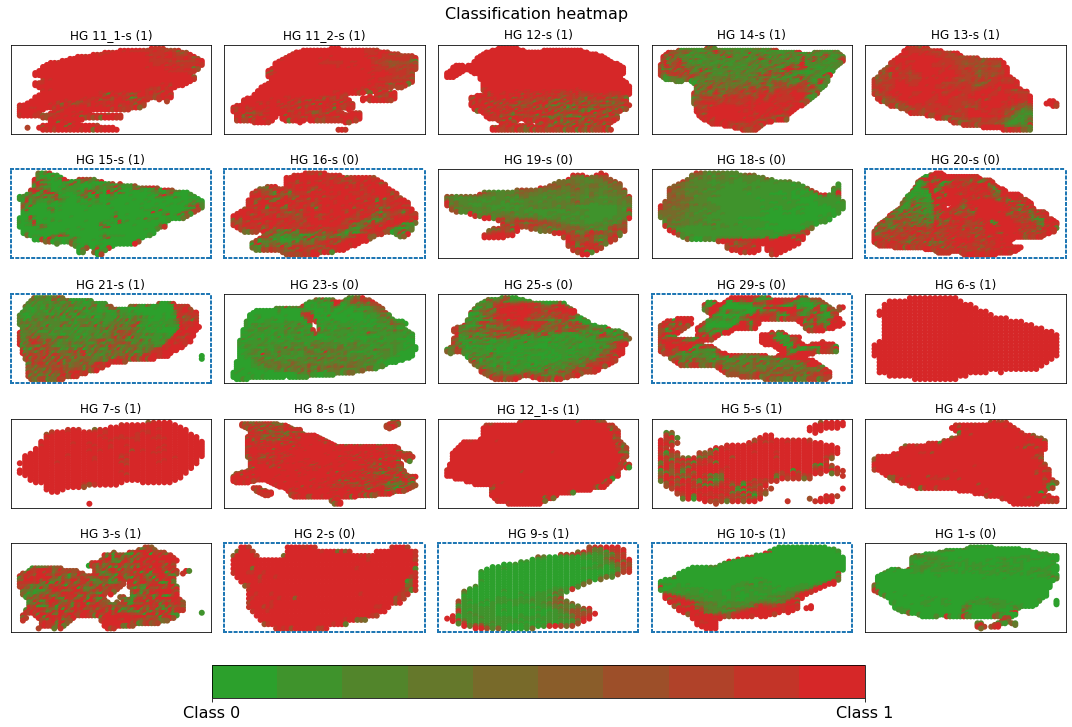

In [29]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

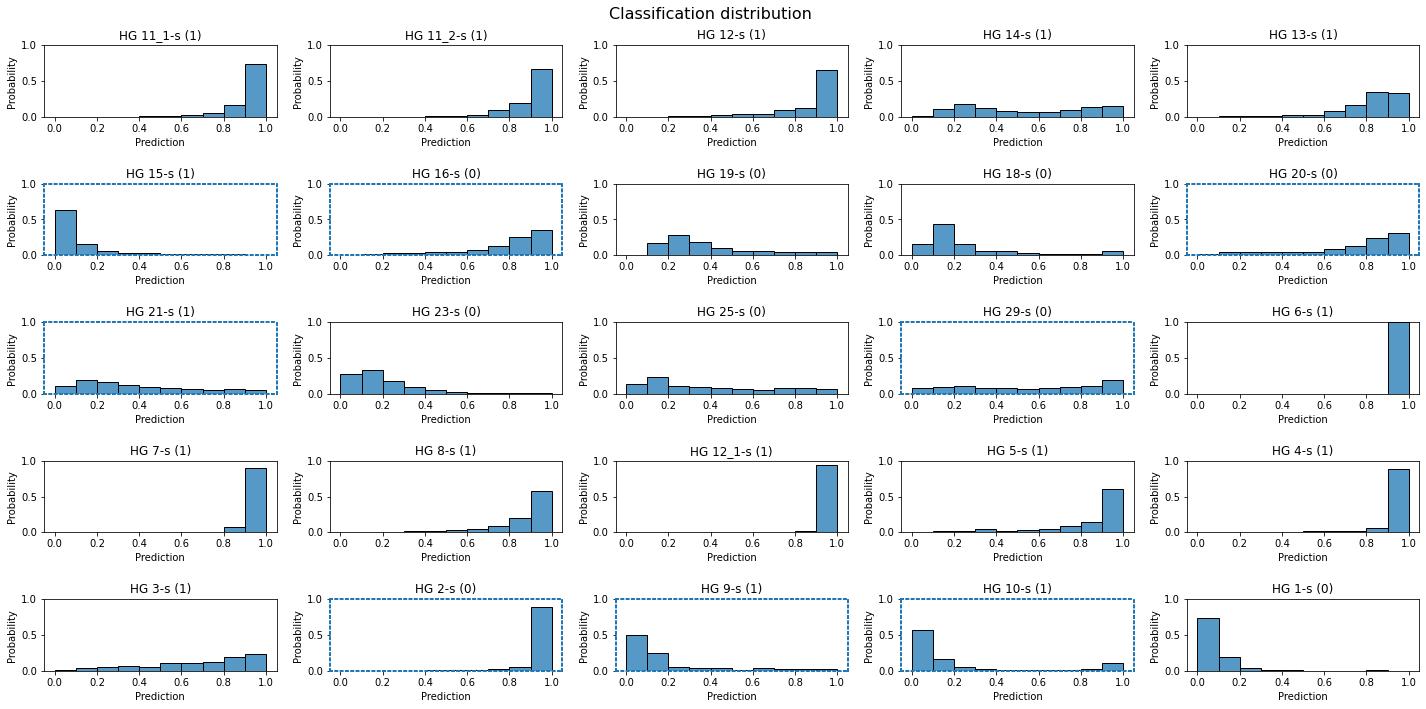

In [30]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0, 1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/section_section_tissue_distribution.png"),
    transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [31]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        s_spectras_info[(s_spectras_info.file_name == key) &
                                        s_spectras_info.is_tissue].x_coordinate,
                        1
                    ),
                    np.expand_dims(
                        s_spectras_info[(s_spectras_info.file_name == key) &
                                        s_spectras_info.is_tissue].y_coordinate,
                        1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/section_section_tissue_spectra_wise_predictions.csv",
    index=False
)

### ***Replica classification:***
Next, let's apply classification on replica samples.

#### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [32]:
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in r_metadata_df.groupby("file_name"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = r_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & r_spectras_info.is_tissue)

  # Filter training data
  r_spectras_info_train = r_spectras_info.loc[train_filter]

  # Get x and y data for training
  X = r_spectras_info_train[["file_name", "idx"]].to_numpy()
  y = r_spectras_info_train["label"].to_numpy()

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Shuffle training labels
  # np.random.shuffle(y_train)

  # Create data generators
  train_generator = create_ds(
      X_train[:, 0], X_train[:, 1].astype("int"), y_train, BATCH_SIZE, True
  )
  validation_generator = create_ds(
      X_val[:, 0], X_val[:, 1].astype("int"), y_val, BATCH_SIZE, True
  )

  # Calculate class weights to make sure no imbalance data affect
  neg, pos = np.bincount(y_train.astype(int))
  weight_for_0 = (1 / neg) * ((neg + pos) / 2.0)
  weight_for_1 = (1 / pos) * ((neg + pos) / 2.0)
  class_weight = {0: weight_for_0, 1: weight_for_1}

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"replica_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False, monitor="val_auc",
      mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  classification_model.compile(
      optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
      loss=losses.BinaryCrossentropy(label_smoothing=0.1), metrics=[
          k_metrics.TruePositives(name='tp'),
          k_metrics.FalsePositives(name='fp'),
          k_metrics.TrueNegatives(name='tn'),
          k_metrics.FalseNegatives(name='fn'),
          k_metrics.BinaryAccuracy(name='accuracy'),
          k_metrics.Precision(name='precision'),
          k_metrics.Recall(name='recall'),
          k_metrics.AUC(name='auc'),
          k_metrics.AUC(name='prc', curve='PR')
      ]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback,
                 model_es_callback], class_weight=class_weight
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

Epoch 1/100
142/142 [==============================] - 39s 259ms/step - loss: 0.2881 - tp: 20000.0000 - fp: 514.0000 - tn: 14958.0000 - fn: 661.0000 - accuracy: 0.9675 - precision: 0.9749 - recall: 0.9680 - auc: 0.9902 - prc: 0.9887 - val_loss: 0.2382 - val_tp: 5141.0000 - val_fp: 39.0000 - val_tn: 3829.0000 - val_fn: 25.0000 - val_accuracy: 0.9929 - val_precision: 0.9925 - val_recall: 0.9952 - val_auc: 0.9988 - val_prc: 0.9988
INFO:tensorflow:Assets written to: ./models/binary_who_grade_classification\replica_excluded_HG 1-r\assets
Epoch 2/100
142/142 [==============================] - 35s 243ms/step - loss: 0.2180 - tp: 20620.0000 - fp: 28.0000 - tn: 15444.0000 - fn: 41.0000 - accuracy: 0.9981 - precision: 0.9986 - recall: 0.9980 - auc: 0.9999 - prc: 0.9999 - val_loss: 0.2181 - val_tp: 5144.0000 - val_fp: 45.0000 - val_tn: 3823.0000 - val_fn: 22.0000 - val_accuracy: 0.9926 - val_precision: 0.9913 - val_recall: 0.9957 - val_auc: 0.9995 - val_prc: 0.9994
INFO:tensorflow:Assets written 

In [33]:
# Create data frame of train metrics
train_metrics_df = pd.DataFrame.from_dict(
    train_metrics, orient='index', columns=[
        "loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall",
        "auc", "prc"
    ]
)
# Save data frame
train_metrics_df.to_csv(f"{FIGURES_PATH}/replica_train_metrics.csv")
# Print
train_metrics_df

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
HG 1-r,0.1990323961,20661.0000000000,0.0000000000,15472.0000000000,0.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000
HG 12-11-r,0.2027184367,18792.0000000000,0.0000000000,17516.0000000000,0.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000
HG 14-13-r,0.2079844624,16557.0000000000,3.0000000000,17513.0000000000,0.0000000000,0.9999119639,0.9998188615,1.0000000000,1.0000000000,0.9999998808
HG 16-15-r,0.1995769143,19431.0000000000,0.0000000000,16172.0000000000,0.0000000000,1.0000000000,1.0000000000,1.0000000000,0.9999999404,1.0000000000
HG 18-19-18-r,0.1988456398,20661.0000000000,0.0000000000,11512.0000000000,0.0000000000,1.0000000000,1.0000000000,1.0000000000,0.9999999404,1.0000000000
HG 29-25-23-21-20-r,0.2052638829,19167.0000000000,0.0000000000,11535.0000000000,0.0000000000,1.0000000000,1.0000000000,1.0000000000,0.9999999404,1.0000000000
HG 6-6-7-r,0.2048314065,18159.0000000000,0.0000000000,17516.0000000000,5.0000000000,0.9998598695,1.0000000000,0.9997247458,0.9999281764,0.9999603629
HG 8-5-4-3-2-r,0.1996030807,14404.0000000000,0.0000000000,15376.0000000000,0.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000
HG 9-10-r,0.2020660192,17453.0000000000,0.0000000000,17517.0000000000,1.0000000000,0.9999713898,1.0000000000,0.9999427199,1.0000000000,0.9999999404


In [34]:
# Create data frame of validation metrics
validation_metrics_df = pd.DataFrame.from_dict(
    validation_metrics, orient='index', columns=[
        "loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall",
        "auc", "prc"
    ]
)
# Save data frame
validation_metrics_df.to_csv(f"{FIGURES_PATH}/replica_validation_metrics.csv")
# Print
validation_metrics_df

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
HG 1-r,0.2146380693,5143.0000000000,57.0000000000,3811.0000000000,23.0000000000,0.9911445379,0.9890384674,0.9955478311,0.9995743036,0.9996770620
HG 12-11-r,0.2159021646,4681.0000000000,53.0000000000,4327.0000000000,17.0000000000,0.9922890663,0.9888044000,0.9963814616,0.9992570281,0.9992485642
HG 14-13-r,0.2241238952,4113.0000000000,64.0000000000,4316.0000000000,26.0000000000,0.9894353747,0.9846779704,0.9937182665,0.9984499812,0.9976707101
HG 16-15-r,0.2120037675,4836.0000000000,39.0000000000,4004.0000000000,22.0000000000,0.9931468368,0.9919999838,0.9954713583,0.9993784428,0.9992355108
HG 18-19-18-r,0.2067493200,5161.0000000000,27.0000000000,2851.0000000000,5.0000000000,0.9960218668,0.9947956800,0.9990321398,0.9998238683,0.9998991489
HG 29-25-23-21-20-r,0.2127822340,4786.0000000000,27.0000000000,2857.0000000000,6.0000000000,0.9957008958,0.9943901896,0.9987478852,0.9998695254,0.9999207258
HG 6-6-7-r,0.2158851922,4517.0000000000,46.0000000000,4334.0000000000,24.0000000000,0.9921533465,0.9899188876,0.9947147965,0.9997202754,0.9997236133
HG 8-5-4-3-2-r,0.2077000737,3583.0000000000,14.0000000000,3830.0000000000,18.0000000000,0.9957017899,0.9961078763,0.9950013757,0.9998860955,0.9998790026
HG 9-10-r,0.2162415385,4349.0000000000,63.0000000000,4316.0000000000,15.0000000000,0.9910785556,0.9857207537,0.9965627789,0.9993090630,0.9986870289


#### ***Evaluation on replica tissue spectra's:***

Next, let's get the prediction of each of left out replica sample spectra's:

In [35]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    r_metadata_df.iterrows(), total=r_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (r_spectras_info["file_name"] == row.sample_file_name) &
      r_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = r_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"replica_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [01:40<00:00,  4.02s/it]


Next, let's get some statistics about each left out section sample predictions:

In [36]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frame of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{FIGURES_PATH}/replica_replica_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 12-r,0.8566588163,0.9811584949,0.9627248049,0.9628048539,0.0091825640,1,1
HG 11-r,0.1040381640,0.9842995405,0.8480792642,0.7692105770,0.2135278285,1,1
HG 14-r,0.0448591821,0.9819810987,0.7938131690,0.7093024254,0.2343923450,1,1
HG 13-r,0.0238225944,0.9688614607,0.7006247044,0.6399565935,0.2392973304,1,1
HG 16-r,0.0507977344,0.9546714425,0.5352311134,0.5301219821,0.2494353801,0,1
HG 15-r,0.0401568376,0.9679546952,0.6591286063,0.6173965335,0.2604664266,1,1
HG 18_1-r,0.0494569130,0.9717639089,0.3551092744,0.4013563991,0.2515222430,0,0
HG 19-r,0.0443052687,0.9829527140,0.8546663523,0.7892350554,0.1852523386,0,1
HG 18_2-r,0.0487905480,0.9740028977,0.5001055002,0.5034192204,0.2302932590,0,1


Next, let's evaluate the classification performance image-wise:

In [37]:
# Get accuracy
accuracy = s_metrics.accuracy_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get balanced accuracy
b_accuracy = s_metrics.balanced_accuracy_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get precision
precision = s_metrics.precision_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get recall
recall = s_metrics.recall_score(
    model_eval.sample_label, model_eval.sample_prediction
)
# Get  f1 score
f1 = s_metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "replica_replica_tissue_image_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.720
Balanced  Accuracy: 0.683
Precision: 0.722
Recall: 0.867
F1 score: 0.788



Next, let's plot the roc curve image-wise:

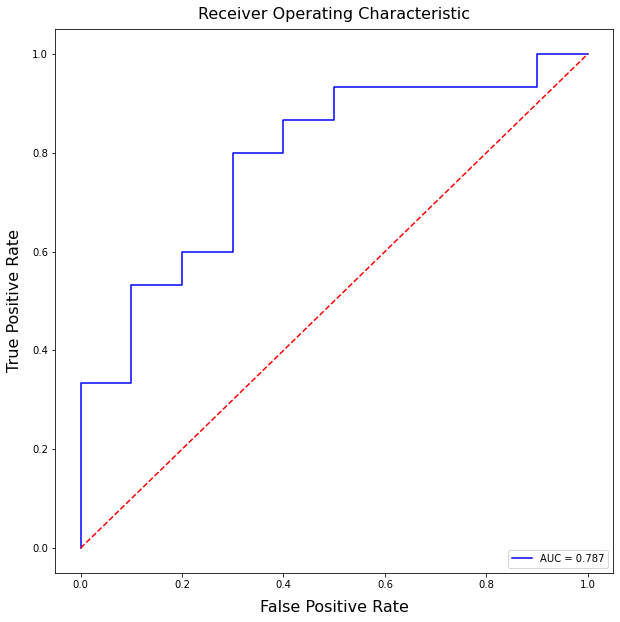

In [38]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = s_metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = s_metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

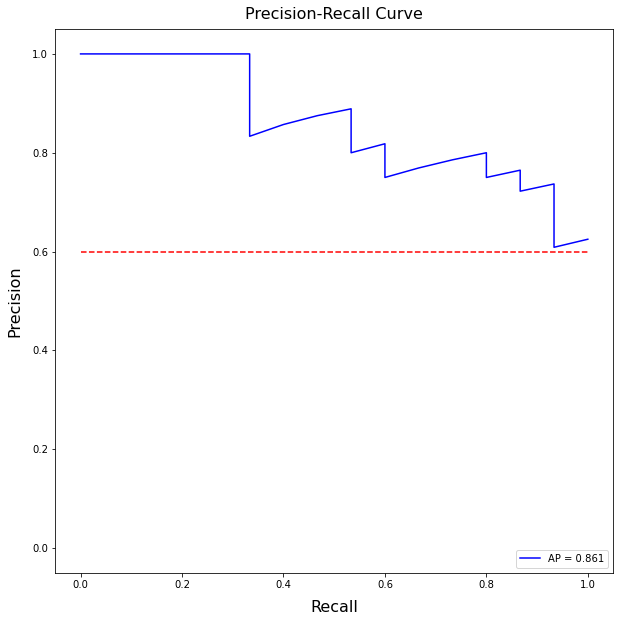

In [39]:
# Compute Receiver operating characteristic
precision, recall, thresholds = s_metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = s_metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [40]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = s_metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = s_metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = s_metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = s_metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = s_metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "replica_replica_tissue_spectra_wise_performance.txt"
with open(f"{FIGURES_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{FIGURES_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.634
Balanced  Accuracy: 0.632
Precision: 0.732
Recall: 0.642
F1 score: 0.684



Next, let's plot the roc curve spectra-wise:

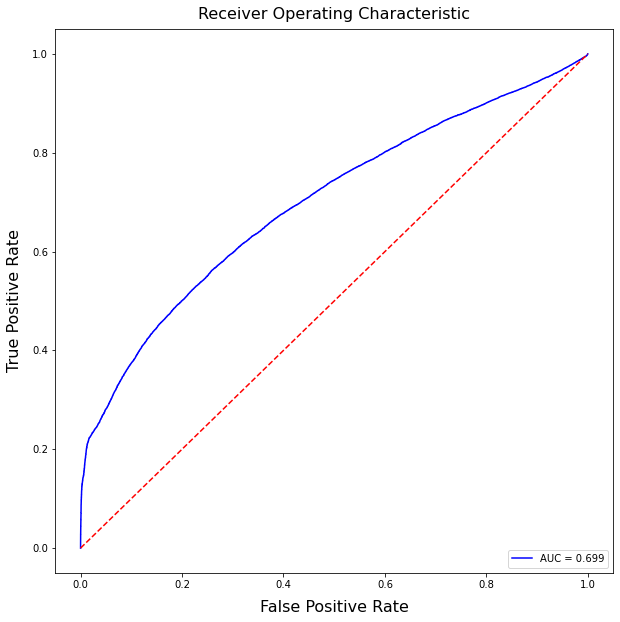

In [41]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = s_metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = s_metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

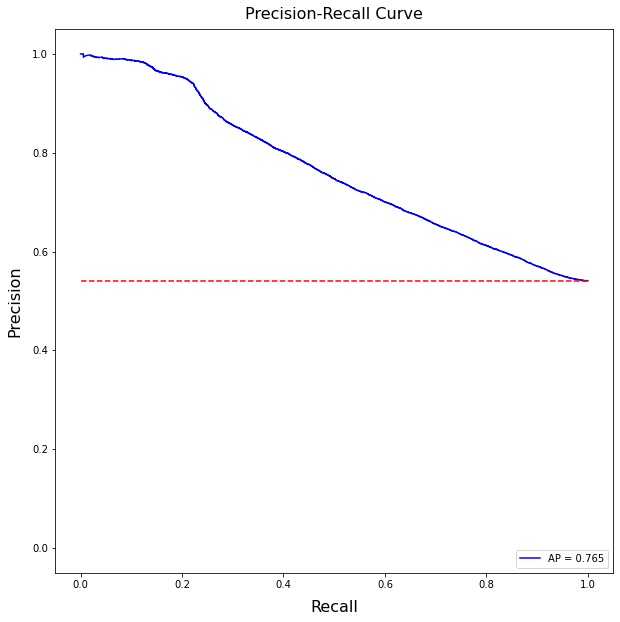

In [42]:
# Compute Receiver operating characteristic
precision, recall, thresholds = s_metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = s_metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

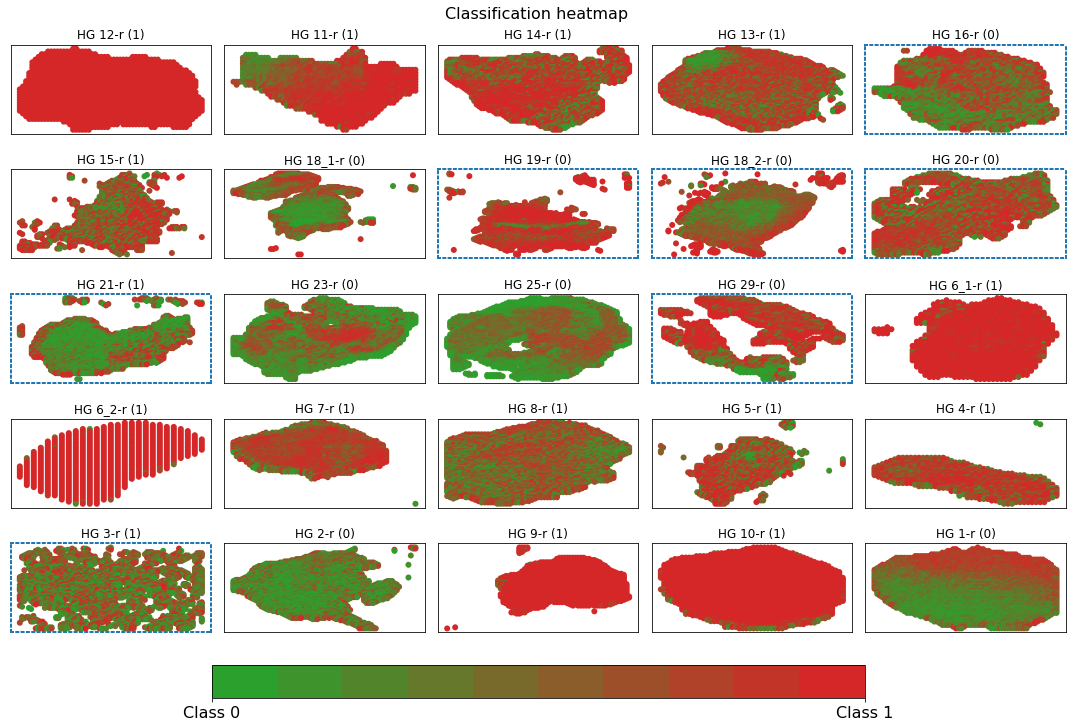

In [43]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].x_coordinate - 1,
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

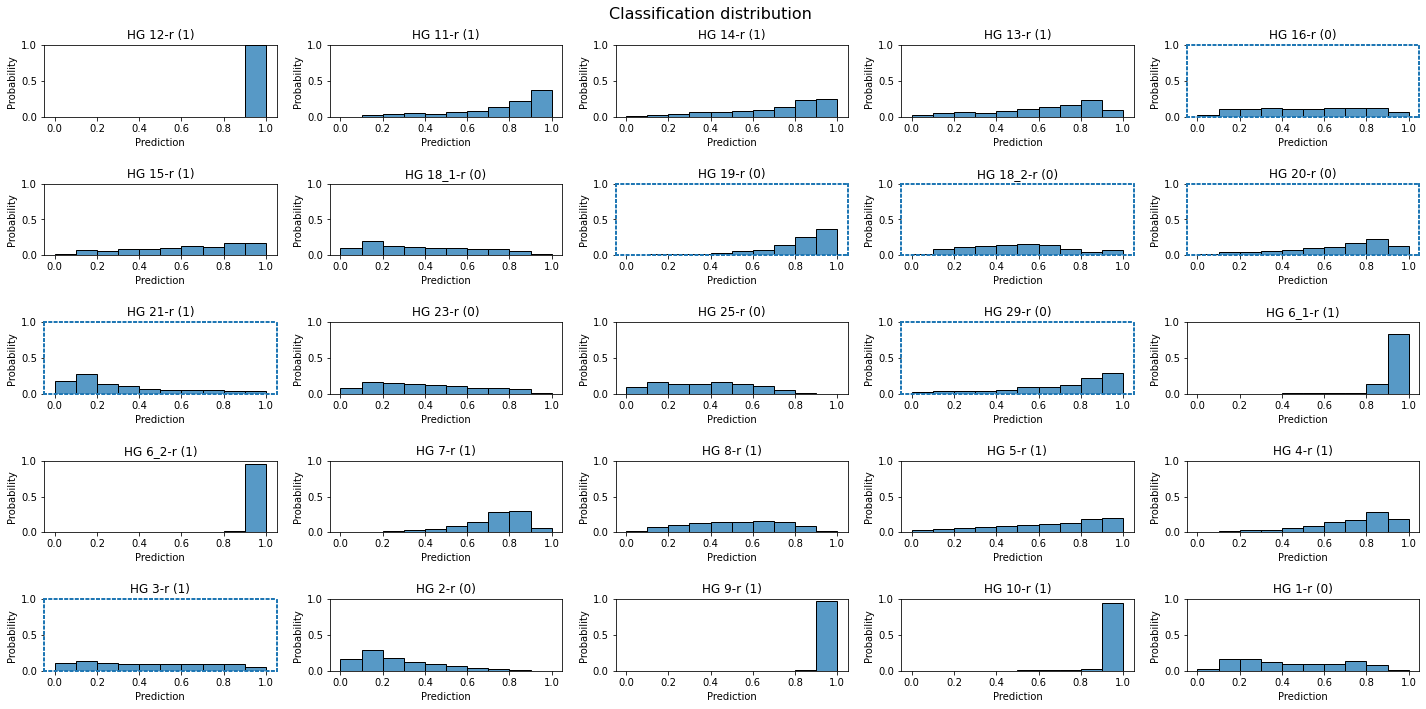

In [44]:
# Create subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0, 1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{FIGURES_PATH}/replica_replica_tissue_distribution.png"),
    transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [45]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        r_spectras_info[(r_spectras_info.file_name == key) &
                                        r_spectras_info.is_tissue].x_coordinate,
                        1
                    ),
                    np.expand_dims(
                        r_spectras_info[(r_spectras_info.file_name == key) &
                                        r_spectras_info.is_tissue].y_coordinate,
                        1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{FIGURES_PATH}/replica_replica_tissue_spectra_wise_predictions.csv",
    index=False
)

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [46]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()